In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Набор данных

Набор данных содержит информацию о состоянии преступности в России за каждый месяц, начиная с 2003 года по 2020.

In [34]:
df = pd.read_csv(r"D:\YandexDisk\datasets\daily-bitcoin-stock-2018-2021.csv").rename( columns={'Unnamed: 0':'date_day'}).rename(str.lower, axis='columns')
date_days = pd.to_datetime(df.pop('date_day'), format='%Y.%m.%d')

my_col_name = 'close_usd'
my_time_name = 'days'
my_plot_cols = ['open_usd', 'high_usd', 'close_usd']

my_width = 24
my_conv_width = 3
my_shift = 1

df.head()

,open_sar,open_usd,high_sar,high_usd,low_sar,low_usd,close_sar,close_usd,volume
0,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [4]:
date_days.head(15)

0    2021-01-30
1    2021-01-29
2    2021-01-28
3    2021-01-27
4    2021-01-26
5    2021-01-25
6    2021-01-24
7    2021-01-23
8    2021-01-22
9    2021-01-21
10   2021-01-20
11   2021-01-19
12   2021-01-18
13   2021-01-17
14   2021-01-16
Name: date_day, dtype: datetime64[ns]

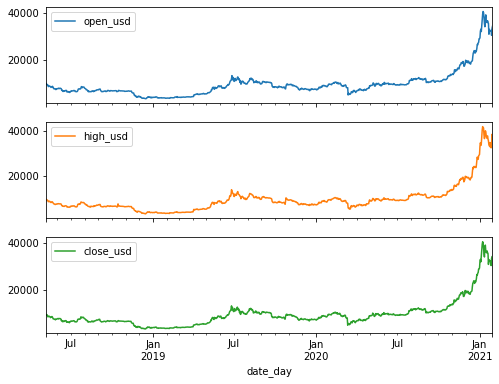

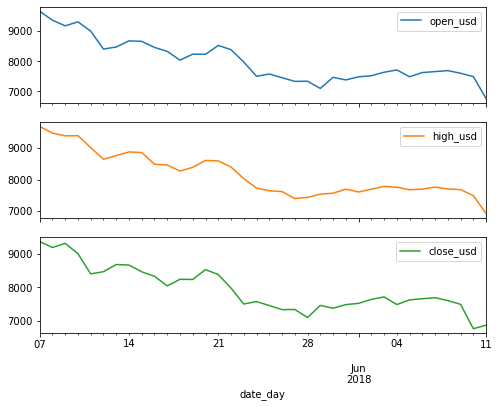

In [5]:
plot_features = df[my_plot_cols]
plot_features.index = date_days
hello = plot_features.plot(subplots=True)

plot_features = df[my_plot_cols][-36:]
plot_features.index = date_days[-36:]
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open_sar,1000.0,34825.322255,21728.028028,12045.197184,24254.558752,30714.632128,38317.311744,152217.334784
open_usd,1000.0,9285.762120,5793.522832,3211.710000,6467.192500,8189.695000,10216.860000,40586.960000
high_sar,1000.0,35789.618165,22785.946842,12288.185600,24686.089152,31321.953152,39077.527200,157329.280000
high_usd,1000.0,9542.880270,6075.604427,3276.500000,6582.255000,8351.630000,10419.562500,41950.000000
low_sar,1000.0,33796.329057,20565.410145,11837.237504,23721.336256,30010.869568,37158.878816,145215.488000
low_usd,1000.0,9011.393200,5483.524463,3156.260000,6325.015000,8002.045000,9907.977500,38720.000000
close_sar,1000.0,34917.483572,21928.280072,12045.234688,24252.946080,30713.263232,38329.725568,152201.770624
close_usd,1000.0,9310.335850,5846.917681,3211.720000,6466.762500,8189.330000,10220.170000,40582.810000
volume,1000.0,53100.498000,35329.832031,5743.000000,30045.750000,43795.500000,64909.250000,402201.000000


## Разбиение данных

Обучение – 70%,
валидация – 20%,
проверка – 10%.

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'open_sar': 0,
 'open_usd': 1,
 'high_sar': 2,
 'high_usd': 3,
 'low_sar': 4,
 'low_usd': 5,
 'close_sar': 6,
 'close_usd': 7,
 'volume': 8}

In [8]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

val_performance = {}
test_performance = {}

## Нормализация данных

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Окно данных (data windowing)

Модели делают набор прогнозов на основе окна последовательных выборок из данных.

Пример:
![](images/data-windowing.png)

In [10]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result

        return result

    def __repr__(self):
        return '\n'.join([
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}'])

    def plot(self, model=None, plot_col='unnamed', plot_time='unnamed', max_subplots=3):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel(plot_time)

## Проверка класса WindowGenerator

In [11]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w1

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [47]
label column name(s): ['close_usd']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w2

total window size: 7
input indices: [0 1 2 3 4 5]
label indices: [6]
label column name(s): ['close_usd']

In [13]:
example_features = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_features)

print('all shapes are: (batch, time, features)')
print(f'window shape: {example_features.shape}')
print(f'inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

all shapes are: (batch, time, features)
window shape: (3, 7, 9)
inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [26]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 6, 9)
labels shape (batch, time, features): (32, 1, 1)


## Одношаговые модели

Модель, которая предсказывает значение одного признака на 1 шаг (в нашем случае 1 месяц) в будущем, основываясь только на текущих условиях.

![](images/model-single-step.png)

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

total window size: 2
input indices: [0]
label indices: [1]
label column name(s): ['close_usd']

In [17]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 1, 9)
labels shape (batch, time, features): (32, 1, 1)


## Линия отсчёта (baseline)

Необходимо предсказать кол-во преступлений в следующем месяце, учитывая текущее значение всех признаков.

Определим модель – линия отсчёта – которая просто возвращает текущее кол-во преступлений в качестве прогноза, тем самым предсказывая никаких изменений. Такая модель имеет смысл, поскольку уровень преступности изменятся в следующем месяце, по сравнением с текущим, небольшим скачком.

![](images/model-baseline.png)

In [18]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [27]:
baseline = Baseline(label_index=column_indices[my_col_name])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
test_performance['baseline'] = baseline.evaluate(single_step_window.test)

4/4 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0281


In [20]:
wide_window = WindowGenerator(
    input_width=my_width, label_width=my_width, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_window

total window size: 25
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
label column name(s): ['close_usd']

In [21]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


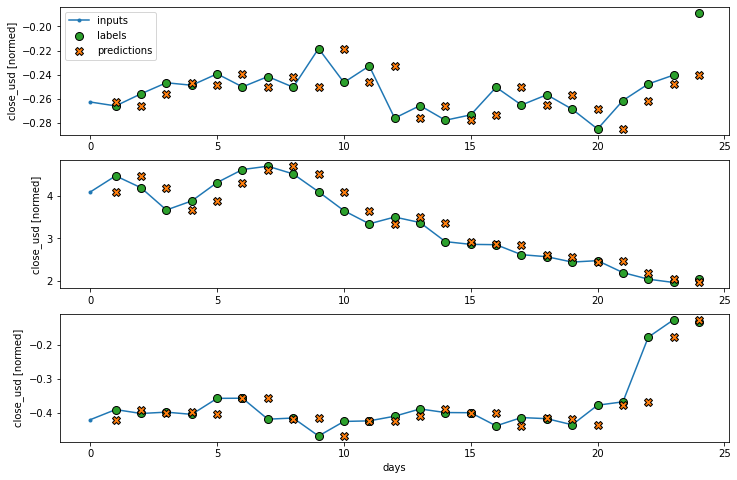

In [22]:
wide_window.plot(baseline, plot_col=my_col_name, plot_time=my_time_name)

## Линейная модель

Линейное преобразование между входом и выходом. Модель ```layers.Dense``` без активации – линейная модель.

Одним из преимуществ линейных моделей является то, что они относительно просты в интерпретации. Вы можете вытащить веса слоя и увидеть вес, назначенный каждому входу:

![](images/model-linear.png)

In [23]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

input shape: (32, 1, 9)
output shape: (32, 1, 1)


In [24]:
def compile_and_fit(model, window, patience=2, epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [25]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 0s 19ms/step - loss: 5.8204 - mean_absolute_error: 1.4723 - val_loss: 5.2261 - val_mean_absolute_error: 2.2340
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 5.0565 - mean_absolute_error: 1.3756 - val_loss: 4.5527 - val_mean_absolute_error: 2.0851
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 4.3931 - mean_absolute_error: 1.2804 - val_loss: 3.9313 - val_mean_absolute_error: 1.9377
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 3.7818 - mean_absolute_error: 1.1896 - val_loss: 3.376

In [28]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


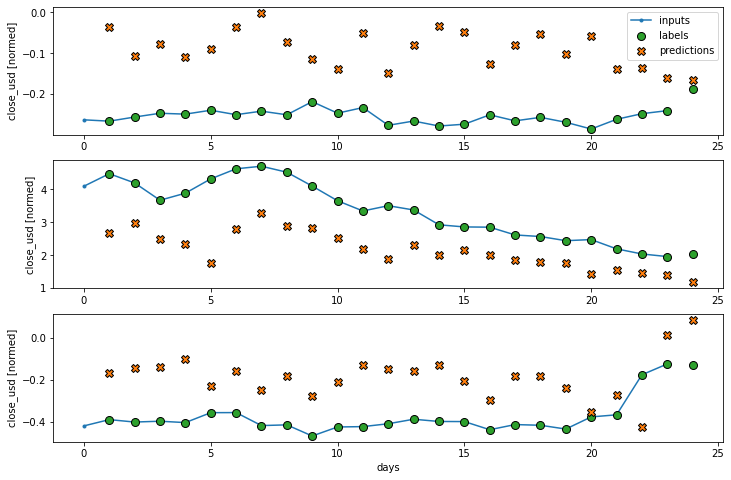

In [29]:
wide_window.plot(linear, plot_col=my_col_name, plot_time=my_time_name)

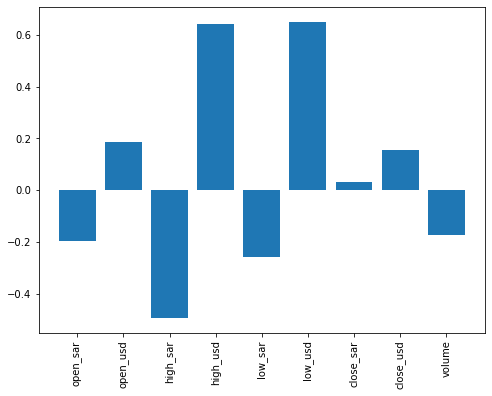

In [30]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Полносвязанная модель (dense)

In [32]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [33]:
%%time
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
test_performance['dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 0s 19ms/step - loss: 0.3368 - mean_absolute_error: 0.3426 - val_loss: 0.0051 - val_mean_absolute_error: 0.0580
Epoch 2/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0197 - mean_absolute_error: 0.0990 - val_loss: 0.0046 - val_mean_absolute_error: 0.0566
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0482 - val_loss: 0.0037 - val_mean_absolute_error: 0.0489
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0380 - val_loss: 0.0021

## Многошаговая полносвязанная модель

Модель будет принимать несколько временных шагов в качестве входных данных для получения одного вывода.

![](images/model-multi-step-dense.png)

In [36]:
conv_window = WindowGenerator(
    input_width=my_conv_width, label_width=1, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
conv_window

total window size: 4
input indices: [0 1 2]
label indices: [3]
label column name(s): ['close_usd']

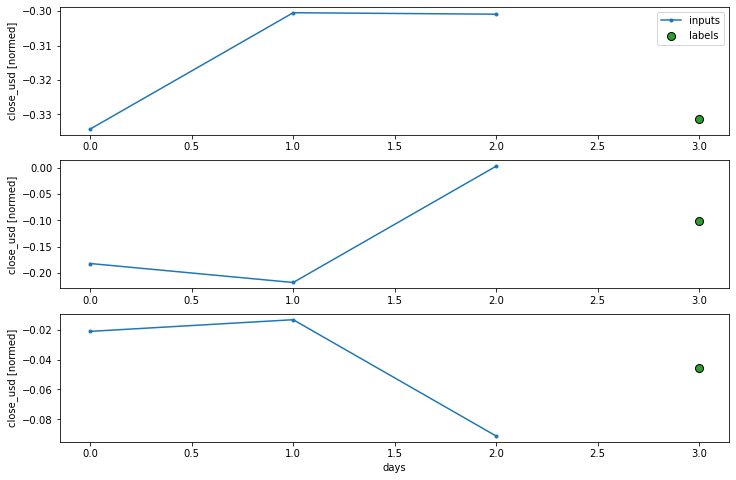

In [38]:
conv_window.plot(plot_col=my_col_name, plot_time=my_time_name)

In [39]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [40]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', multi_step_dense(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [42]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['multi_step_dense'] = multi_step_dense.evaluate(conv_window.val)
test_performance['multi_step_dense'] = multi_step_dense.evaluate(conv_window.test)

4/4 [==============================] - 0s 0s/step - loss: 7.9558e-04 - mean_absolute_error: 0.0223
Wall time: 5.2 s


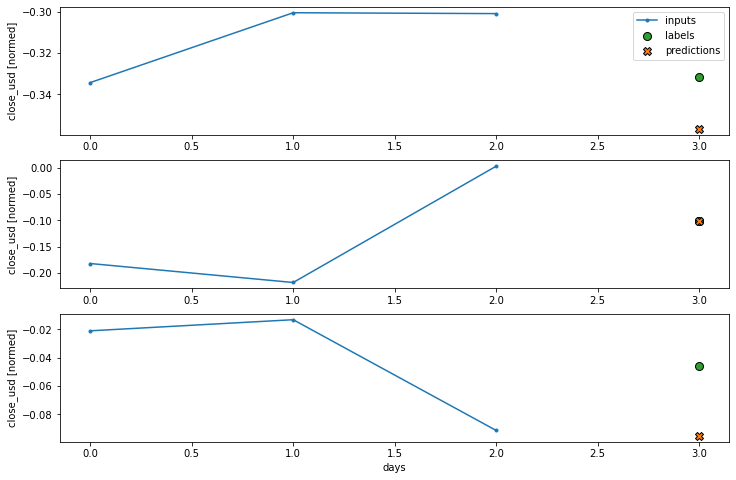

In [44]:
conv_window.plot(multi_step_dense, plot_col=my_col_name, plot_time=my_time_name)

Основным недостатком этого подхода является то, что полученная модель может быть выполнена только на входных окнах именно такой формы.

In [45]:
print('input shape:', wide_window.example[0].shape)
try:
    print('output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

input shape: (32, 24, 9)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,216], In[1]: [27,32] [Op:MatMul]


## Свёрточная нейронная сеть

In [40]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(my_conv_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [41]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', conv_model(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [43]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['conv'] = conv_model.evaluate(conv_window.val)
test_performance['conv'] = conv_model.evaluate(conv_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 7.4369e-04 - mean_absolute_error: 0.0214
Wall time: 3.79 s
